# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Helper Functions

In [2]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    TODO: Describe alogrithm
    """
    left_lines  = []
    right_lines = []
    
    left_m  = 0
    right_m = 0

    top_left_x = 0;
    top_left_y = 0;
    
    high_left_x = 0;
    high_left_y = img.shape[0];
    
    top_right_x = 0;
    top_right_y = 0;
    
    high_right_x = 0;
    high_right_y = img.shape[0];
    
    bottom_left_x = 0;
    bottom_left_y = img.shape[0]
    
    bottom_right_x = 0;
    bottom_right_y = img.shape[0]
   
    for line in lines:
        for x1,y1,x2,y2 in line:
            m = ((y2-y1)/(x2-x1))
            # print(m)
            if (m < -0.5):
                left_lines.append(line)
                left_m += m
                top_left_x += x2 if (y1 > y2) else x1
                top_left_y += y2 if (y1 > y2) else y1
                
                if (y1 > y2 and y2 < high_left_y):
                    high_left_x = x2
                    high_left_y = y2
                elif (y2 > y1 and y1 < hight_left_y):
                    high_left_x = x1
                    high_left_y = y1
                    
            elif (m > 0.5): 
                right_lines.append(line)
                right_m += m
                top_right_x += x2 if (y1 > y2) else x1
                top_right_y += y2 if (y1 > y2) else y1
                
                if (y1 > y2 and y2 < high_right_y):
                    high_right_x = x2
                    high_right_y = y2
                elif (y2 > y1 and y1 < high_right_y):
                    high_right_x = x1
                    high_right_y = y1
    
    no_of_left_lines = len(left_lines)
    no_of_right_lines = len(right_lines)
    
    if (no_of_left_lines > 0 and  no_of_right_lines > 0):
        left_m  = left_m / len(left_lines)
        right_m = right_m / len(right_lines)
        
        top_left_x = high_left_x
        top_left_y = high_left_y

        top_right_x = high_right_x
        top_right_y = high_right_y

        bottom_left_x  = top_left_x + (bottom_left_y - top_left_y) / left_m
        bottom_right_x = top_right_x + (bottom_right_y - top_right_y) / right_m

        cv2.line(img, (int(top_left_x), int(top_left_y)), (int(bottom_left_x), int(bottom_left_y)), color, thickness)
        cv2.line(img, (int(top_right_x), int(top_right_y)), (int(bottom_right_x), int(bottom_right_y)), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Build a Lane Finding Pipeline



In [3]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    
    # Lane detection algorithm params

    # kernal size of gaussian blur
    kernal_size = 9

    # threshold for canny edge detection
    low_threshold  = 50
    high_threshold = 150

    # params for hough transform
    rho          = 1
    theta        = np.pi/180
    threshold    = 20
    min_line_len = 1 
    max_line_gap = 120
    
    # load image
    in_img = image
    
    # convert to gray scale
    gray_scale_img = grayscale(in_img);
    
    # apply gaussian blur
    blur_img = gaussian_blur(gray_scale_img, kernal_size)
    
    # apply canny edge detection
    edges_img = canny(blur_img, low_threshold, high_threshold)
    
    # apply mask to focus on region of interest
    img_shape    = in_img.shape;
    left_bottom  = [100, img_shape[0]]
    right_bottom = [img_shape[1] - 50, img_shape[0]]
    top_left     = [img_shape[1]/2 - 10, img_shape[0]/2 + 50]
    top_right    = [img_shape[1]/2 + 10, img_shape[0]/2 + 50]
    
    vertices   = np.array([[left_bottom, top_left, top_right, right_bottom]], dtype=np.int32)
    masked_img = region_of_interest(edges_img, vertices)
    
    # apply hough transform
    lines_img = hough_lines(masked_img, rho, theta, threshold, min_line_len, max_line_gap)
    
    # overlay result image on top of original image
    out_img = weighted_img(lines_img, in_img);
    
    result = out_img

    return result

## Test Images

In [4]:
import os
# Get all files in the test_images folder
in_img_dir  = "test_images/"
out_img_dir = "test_images_output/" 
files       = os.listdir(in_img_dir)

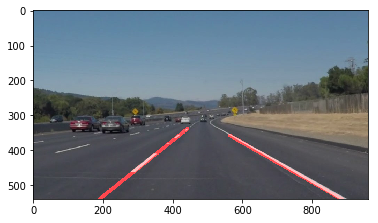

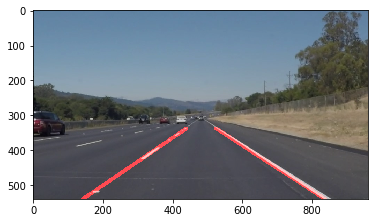

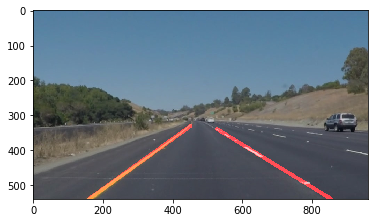

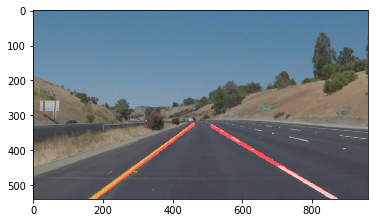

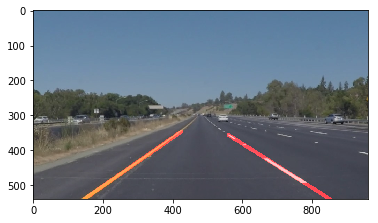

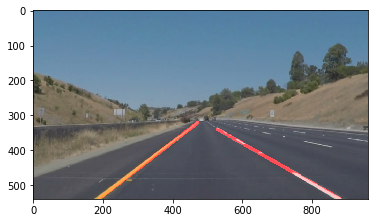

In [5]:
# Lane detection algorithm params

# for each image
for file in files:
    # load image
    in_img = mpimg.imread(in_img_dir + file)
    
    out_img = process_image(in_img)
    
    # show image
    # print('This image is:', type(out_img), 'with dimensions:', out_img.shape)
    plt.figure()
    plt.imshow(out_img)

## Test on Videos

Testing on the following videos.

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [7]:
white_output = 'test_videos_output/solidWhiteRight.mp4'

## To test on a sub clip uncomment the following line and change the start and end time in seconds.
## clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)

clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")

white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:02<00:00, 87.56it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 2.27 s, sys: 653 ms, total: 2.92 s
Wall time: 2.92 s


In [8]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [9]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'

## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)

clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:08<00:00, 79.34it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 7.93 s, sys: 1.94 s, total: 9.88 s
Wall time: 9.02 s


In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [11]:
challenge_output = 'test_videos_output/challenge.mp4'

## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)

clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:09<00:00, 27.50it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 6.39 s, sys: 2.37 s, total: 8.76 s
Wall time: 10.2 s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))